## Imports

In [1]:
from base_Imports_and_Functions import *

Father_19_0_23 = xr.open_dataset(savenet_path +'father_0_23.nc')
Method_values = xr.open_dataset(savenet_path+'Method_values.nc')

## PBL height flights

In [3]:
def save_max_height_traces_carto_meth(img_extent,nlon,nlat):
    days = ['IGC_21-08-2023/']
    ndarray_save_path = 'T:/C2H/STAGES/LEO_BARROIS/ndarray/maximum_height_map/'
    data_path = 'T:/C2H/STAGES/LEO_BARROIS/ndarray/traces/'
    type_vols = ['Parapente/','Planeur/']
    
    lons = np.linspace(img_extent[0], img_extent[1], nlon)
    lats = np.linspace(img_extent[2],img_extent[3], nlat)
    
    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
    
    for j in range(2):  
        for i in range(1):
            values = np.zeros((nlat,nlon))
            path = data_path + days[i] + type_vols[j]
            files = [f for f in os.listdir(path) if f.endswith('.npy')]
            for k in files :  
                datas = np.load(os.path.join(path,k))[:,:-1] 
                values = pre_max_height_traces_carto(values,datas,nlat-1,nlon-1,lons[:-1],lats[:-1])
    np.save(savenpa_path+days[i][:-1]+str(nlat)+'_values.npy',values)
    np.load = np_load_old

In [4]:
img_extent = (4.7942, 8.1545, 43.3545, 46.6707)
nlon_meth = np.arange(5,150,5)
nlat_meth = np.arange(5,150,5)
for i in tqdm(range(len(nlon_meth))):
    save_max_height_traces_carto_meth(img_extent,nlon_meth[i],nlat_meth[i])

  0%|                                                                                           | 0/29 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [3]:
nlon_meth = np.arange(5,75,5)
nlat_meth = np.arange(5,75,5)

days = ['IGC_21-08-2023/']
min = []
max = []
mean = []
std = []
low_quart = []
mean_quart = []
high_quart = []

for j in range(len(nlon_meth)):
    data_pbl = np.load('T:/C2H/STAGES/LEO_BARROIS/ndarray/method_height/'+days[0][:-1]+str(nlon_meth[j])+'.npy')
    min.append(data_pbl[0])
    max.append(data_pbl[1])
    mean.append(data_pbl[2])
    std.append(data_pbl[3])
    low_quart.append(data_pbl[4])
    mean_quart.append(data_pbl[5])
    high_quart.append(data_pbl[6])

num_events = len(nlon_meth)
num_data_points = 7

Method_values = xr.Dataset(
    {
        'min': (['event'], np.ravel(min).astype(np.float32)),
        'max': (['event'], np.ravel(max).astype(np.float32)),
        'mean': (['event'], np.array(mean).astype(np.float32)),
        'std': (['event'], np.array(std).astype(np.float32)),
        'low_quart': (['event'], np.array(low_quart).astype(np.float32)),
        'high_quart': (['event'], np.array(high_quart).astype(np.float32)),
        'mean_quart': (['event'], np.array(mean_quart).astype(np.float32))
    },
    coords={
        'event': np.arange(num_events)
    },
)

Method_values.to_netcdf(savenet_path+'Method_values.nc')

<xarray.Dataset>
Dimensions:     (event: 14)
Coordinates:
  * event       (event) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13
Data variables:
    min         (event) float32 3.09e+03 1.788e+03 1.25e+03 ... 750.0 828.0
    max         (event) float32 5.214e+03 5.214e+03 ... 5.214e+03 5.214e+03
    mean        (event) float32 4.058e+03 3.758e+03 ... 3.535e+03 3.524e+03
    std         (event) float32 2.055e+03 1.928e+03 ... 1.729e+03 1.713e+03
    low_quart   (event) float32 3.392e+03 3.049e+03 ... 2.726e+03 2.735e+03
    high_quart  (event) float32 4.789e+03 4.534e+03 ... 4.259e+03 4.24e+03
    mean_quart  (event) float32 4.072e+03 3.736e+03 ... 3.597e+03 3.586e+03

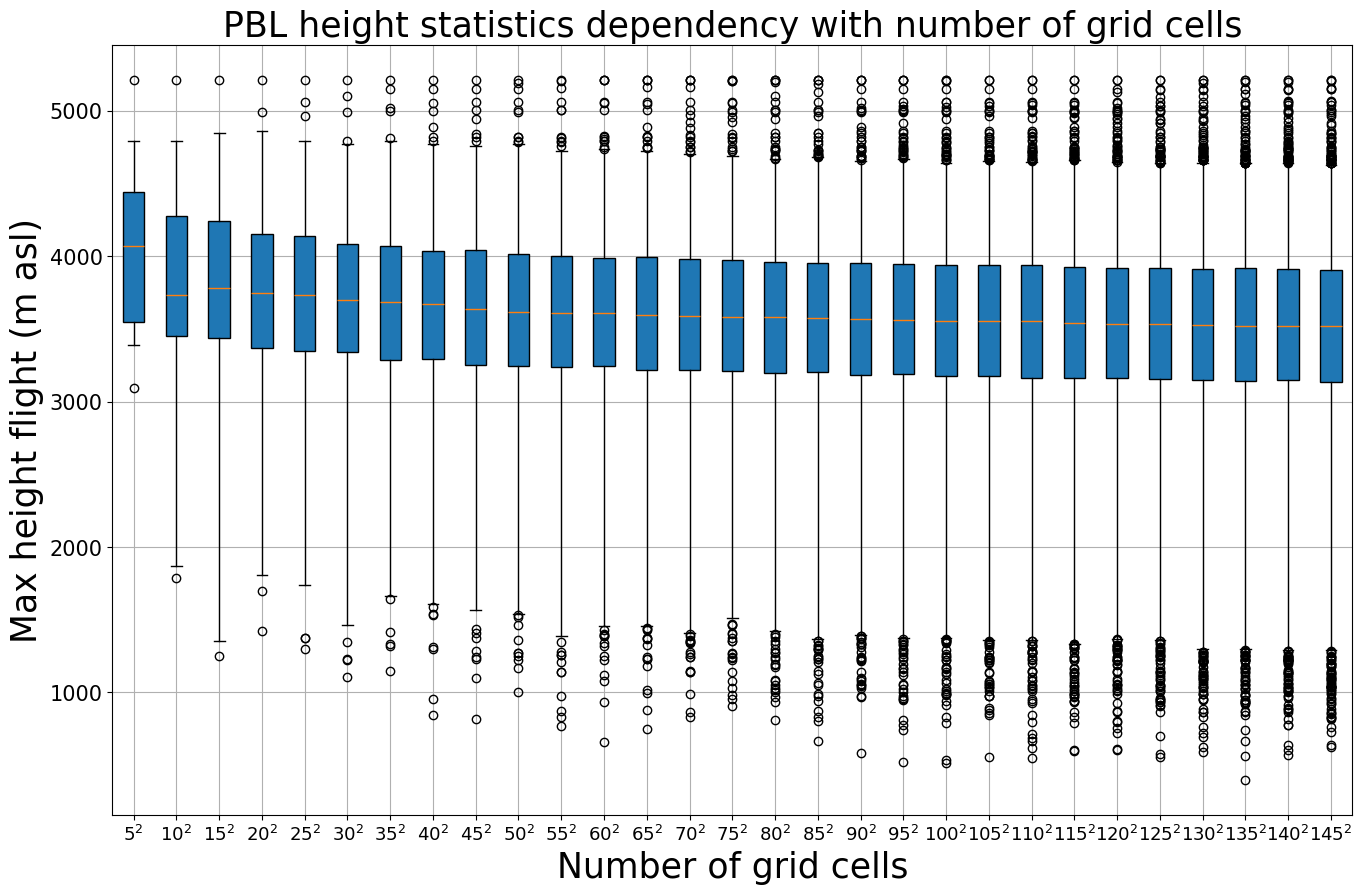

In [15]:
fig, ax1 = plt.subplots(figsize=(16, 10))

ax1.boxplot(res_f, vert=True, patch_artist=True,whis = (1, 99))
#plt.violinplot(res_f,showmedians=True)
#plt.plot(np.arange(1,30),[3510*1 for i in np.arange(1,30)],'--r')

plt.title('PBL height statistics dependency with number of grid cells',fontsize = 25)
ax1.set_xlabel('Number of grid cells',fontsize = 25)
ax1.set_ylabel('Max height flight (m asl)',fontsize = 25)
ax1.set_xticks(np.arange(1,30), ['$'+str(i)+'^2$' for i in np.arange(5,150,5)],fontsize = 13)
ax1.set_yticks(np.arange(1,6,1)*1000, np.arange(1,6,1)*1000,fontsize = 15)

ax1.grid(True)
plt.savefig('T:/C2H/STAGES/LEO_BARROIS/figures/method_PBL_bbox.png')
plt.show()

## Simu

In [8]:
Father_19_0_23_12 = Father_19_0_23.where(
    (Father_19_0_23['heure'] == 12),
    drop = True)

ngridcells = np.arange(5,150,5)

moustaches = [[] for i in range(len(ngridcells))]

min_lon = 4.5
max_lon = 8.3
min_lat = 43.6
max_lat = 46.3

for i in tqdm(range(len(ngridcells))):

    res_i = np.zeros((ngridcells[i],ngridcells[i]))

    lons = np.linspace(min_lon,max_lon,ngridcells[i])
    lats = np.linspace(min_lat,max_lat,ngridcells[i])
    dlon = lons[1]-lons[0]
    dlat = lats[1]-lats[0]
    
    for j in range(len(lons)-1):
        for k in range(len(lats)-1):
            xarray_r = Father_19_0_23_12.where(
                (Father_19_0_23_12['lon'] >= lons[j]) & (Father_19_0_23_12['lon'] <= lons[j+1]) & 
                (Father_19_0_23_12['lat'] >= lats[k]) & (Father_19_0_23_12['lat'] <= lats[k+1]),
                drop = True)
            
            if len(xarray_r['lat']) != 0 :
                
                lon = (lons[j]+lons[j+1])/2
                lat = (lats[k]+lats[k+1])/2
        
                indx = int((lon - min_lon)/dlon)+1
                indy = int((lat - min_lat)/dlat)+1
                
                if 0<=indx<=ngridcells[i] and 0<=indy<=ngridcells[i]:
                    res_i[indy,indx] = np.nanmax(xarray_r['BLH'].values)
        
                else :
                    res_i[indy,indx] = np.nan

    moustaches[i] = np.ravel(res_i).copy()

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [19:00<00:00, 39.34s/it]


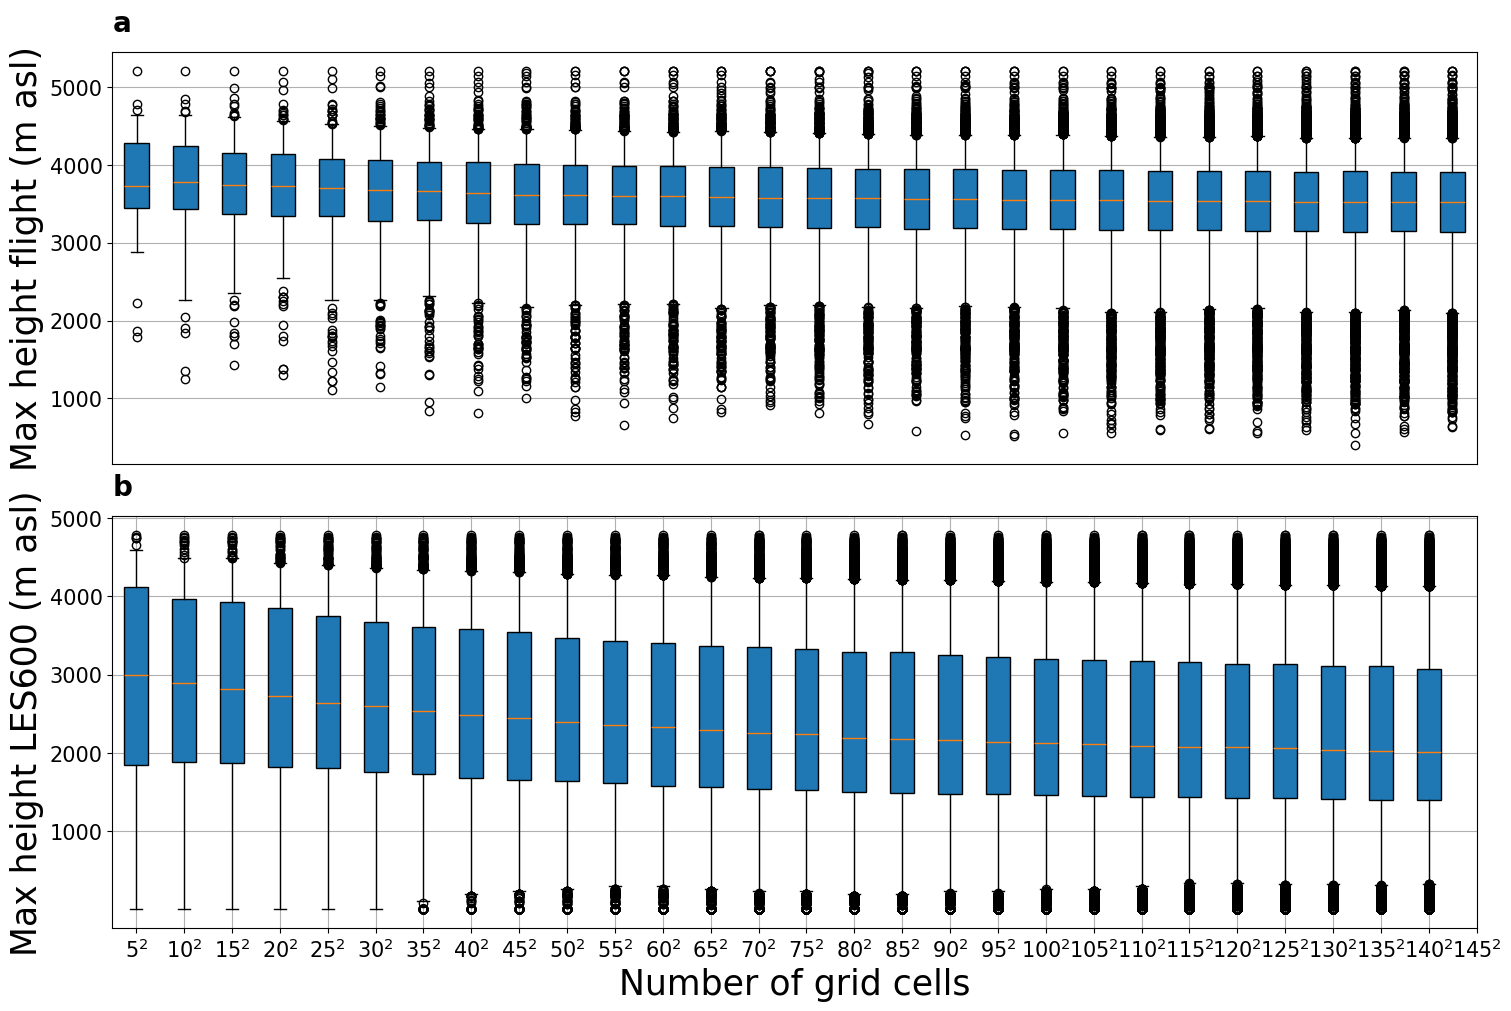

In [22]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (15,10), layout = 'constrained')

for i in range(2):
    ax = axs[i]
    
    if i%2 == 1 :
        list = moustaches.copy()
        xticks = np.arange(1,30)
        xlabels = ['$'+str(i)+'^2$' for i in np.arange(5,150,5)]
        ax.set_xlabel('Number of grid cells',fontsize = 25)
        ax.set_ylabel('Max height LES600 (m asl)',fontsize = 25)
    else :
        ax.set_ylabel('Max height flight (m asl)',fontsize = 25)
        list = res_f.copy()
        xticks = []
        xlabels = []
    
    ax.boxplot(list[1:], vert=True, patch_artist=True,whis = (5, 95))
    ax.set_xticks(xticks,xlabels,fontsize = 15)
    ax.set_yticks(np.arange(1,6,1)*1000, np.arange(1,6,1)*1000,fontsize = 15)
    ax.grid(True)

for i in range(2):
    ax = axs[i]
    ax.text(0, 1.05, string.ascii_lowercase[i], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.savefig('T:/C2H/STAGES/LEO_BARROIS/figures/method_PBL_bbox_updated.png')